In [1]:
from datahandler import DataReader, DataWriter
from configuration import BaseConfig
import pandas as pd

# config = BaseConfig().get_args(db_name="fb15k-237")

# Tests

In [6]:
df = pd.read_csv("datasets/FB15K-237/processed/train.csv")

In [8]:
df.head(3)

,head-mid,relation,tail-mid,head-mid2name,tail-mid2name,head-mid2taxonomy,tail-mid2taxonomy,head-levels,tail-levels
0,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0,Mighty Morphin Power Rangers,Wendee Lee,"['wordnet_event_100029378', 'wordnet_show_1066...","['wordnet_writer_110794014', 'wordnet_director...","['Level-1', 'Level-2-event']","['Level-1', 'Level-3-person-writer', 'Level-2-..."
1,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_,Michelle Rodriguez,Naveen Andrews,"['wordnet_writer_110794014', 'wordnet_female_1...","['wordnet_man_110287213', 'wordnet_person_1000...","['Level-1', 'Level-3-person-writer', 'Level-2-...","['Level-1', 'Level-3-person-scientist', 'Level..."
2,/m/04nrcg,/soccer/football_team/current_roster./soccer/f...,/m/02sdk9v,Maldives national football team,Forward,['wordnet_organization_108008335'],"['wordnet_person_100007846', 'wordnet_basketba...",['Level-1'],"['Level-1', 'Level-3-person-player']"


In [14]:
levels_str = df['head-levels'].tolist()

In [15]:
levels_lst = [eval(levels) for levels in levels_str]

In [21]:
levels_cleaned = [[level[:7] for level in levels] for levels in levels_lst  ]

In [95]:
idx = 5000
levels_cleaned[idx]

['Level-1', 'Level-3']

In [96]:
levels_lst[idx]

['Level-1', 'Level-3-person-player']

In [97]:
df.shape

(82423, 9)

In [98]:
df['head-mid2taxonomy'].tolist()[idx]

"['wordnet_person_100007846', 'wordnet_basketball_player_109842047']"

In [89]:
# 'wordnet_writer_110794014'

# 'wordnet_writer_110801291' --->‌ I add this

In [90]:
df['head-mid2name'].tolist()[idx]

'Michael Sembello'

In [ ]:
# idx = 3000
# 'Michael Sembello'
# ['Level-1', 'Level-2-person', 'Level-3-person-writer', 'Level-3-person-artist']
# "['wordnet_writer_110794014', 'wordnet_songwriter_110624540', 'wordnet_man_110287213', 'wordnet_person_100007846', 'wordnet_male_109624168', 'wordnet_artist_109812338', 'wordnet_performer_110415638', 'wordnet_composer_109947232', 'wordnet_creator_109614315']"



# FB15k-237

In [1]:
from configuration import BaseConfig
from datahandler import DataReader, DataWriter
import pandas as pd
import os

config = BaseConfig().get_args(db_name="fb15k-237")

In [2]:
def add_levels(items_lst, mapper):
    mapped_levels_lst = []
    for items in items_lst:
        mapped_level = []
        if str(items) != 'nan':
            for item in eval(str(items)):
                if mapper.get(item, "NA") != "NA":
                    mapped_level.append(mapper.get(item))
        mapped_levels_lst.append(list(set(mapped_level)))
    return mapped_levels_lst

def add_levels_to_df(df, level1, level2, level3):
    df['level-1'] = add_levels(df['entclass'].tolist(), level1)
    df['level-2'] = add_levels(df['entclass'].tolist(), level2)
    df['level-3'] = add_levels(df['entclass'].tolist(), level3)
    return df

def convert_mid2names(df, mid2name_mapper, dataset_name):
    print("-"*40)
    print(f"working on dataset in converting MID2Names: {dataset_name}")
    df['head-mid2name'] = df['head-mid'].map(mid2name_mapper)
    df['tail-mid2name'] = df['tail-mid'].map(mid2name_mapper)
    old_size = df.shape[0]
    # df = df.dropna()
    print(f"Number of NANS in {dataset_name} set is: {old_size - df.shape[0]}")
    print(f"Current size of {dataset_name} is:{df.shape[0]}")
    return df

def creat_freebase_fb15kbased_mapper(dir_path):
    mid2names_dict = {}
    for js_file in os.listdir(dir_path):
        js_file_path = os.path.join(dir_path, js_file)
        fold_data = DataReader.load_json(js_file_path)
        for key, folds in fold_data.items():
            mid2names_dict_lst = []
            for fold in folds:
                try:
                    _, rel, tail = fold[2:-6].split("\\t")
                    if "type.object.name" in rel and "@en" in tail:
                        mid2names_dict_lst.append(tail.split("@")[0][1:-1])
                except:
                    continue
            if len(mid2names_dict_lst) != 0:
                mid2names_dict["/"+key.replace(".", "/")] = mid2names_dict_lst
    mid2names_dict = {key: values[0] for key, values in mid2names_dict.items()}
    return mid2names_dict

def create_mid2entclass_mapper(freebase_types_path, freebase_hierarchy):
    print("-"*40)
    type_df = DataReader.load_csv(freebase_types_path, sep='\t', names=["mid", "wordnet_type"])
    hierarchy = DataReader.load_json(freebase_hierarchy)

    wordnet_types_to_consider = []
    for _, level_dict in hierarchy.items():
        for wordnet_type, _ in level_dict.items():
            wordnet_types_to_consider.append(wordnet_type)
    wordnet_types_to_consider = list(set(wordnet_types_to_consider))    

    type_df = type_df[type_df['wordnet_type'].isin(wordnet_types_to_consider)]
    print("Shape of WordNet types dataframe is:", type_df.shape[0])
    print("Number of unique values for WordNet types are:", len(type_df['wordnet_type'].unique()))

    mid2entclass_mapper = {}
    for mid, wordnet_type in zip(type_df['mid'].tolist(), type_df['wordnet_type'].tolist()):
        if mid not in mid2entclass_mapper:
            mid2entclass_mapper[mid] = []
        mid2entclass_mapper[mid].append(wordnet_type)
    print(f"At the end size of MID2EntClass mapper is:{len(mid2entclass_mapper)}")
    return mid2entclass_mapper

def convert_mid2ent_classes(df, mid2entclass_mapper, dataset_name):
    print("-"*40)
    print(f"working on dataset in converting MID2EntClass: {dataset_name}")
    df['head-mid2entclass'] = df['head-mid'].map(mid2entclass_mapper)
    df['tail-mid2entclass'] = df['tail-mid'].map(mid2entclass_mapper)
    old_size = df.shape[0]
    df = df.dropna(subset=['head-mid2entclass', 'tail-mid2entclass'])
    print(f"Number of NANS in {dataset_name} set is: {old_size - df.shape[0]}")
    print(f"Current size of {dataset_name} is:{df.shape[0]}")
    return df

def create_level_mapper(freebase_hierarchy):
    hierarchy = DataReader.load_json(freebase_hierarchy)
    level_mappers = {"level-1":{}, "level-2":{}, "level-3":{}}
    for level, level_dict in hierarchy.items():
        for wordnet_type, level_class in level_dict.items():
            level_mappers[level][wordnet_type] = level_class
    return level_mappers['level-1'], level_mappers['level-2'], level_mappers['level-3']

def make_entity_df(df, dataset_name):
    df_ent = pd.concat([
            df[['head-mid', 'head-mid2name', 'head-mid2entclass']].rename(columns={'head-mid':"mid", 'head-mid2name':"name", 'head-mid2entclass':"entclass"}), 
            df[['tail-mid', 'tail-mid2name', 'tail-mid2entclass']].rename(columns={'tail-mid':"mid", 'tail-mid2name':"name", 'tail-mid2entclass':"entclass"})
            ]).reset_index(drop=True)
    print("-"*40)
    print(f"{dataset_name} size before removing duplicates based on [mid, name] is:{df_ent.shape[0]}")
    df_ent = df_ent.drop_duplicates(subset=['mid', 'name'], keep='first').reset_index()
    print(f"Current size  after droping duplicates is: {df_ent.shape[0]}")
    return df_ent

In [3]:
# load datasets
train, test, valid = DataReader.load_csv(config.raw_train, sep='\t', names=["head-mid", "relation", "tail-mid"]), \
                     DataReader.load_csv(config.raw_test, sep='\t',  names=["head-mid", "relation", "tail-mid"]), \
                     DataReader.load_csv(config.raw_valid, sep='\t', names=["head-mid", "relation", "tail-mid"])

In [4]:
train.head(2)

,head-mid,relation,tail-mid
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0


In [5]:
# 1. Make replacement for converting MID2Name      ---> this will be for relationship extraction
# load and create mid2names
mid2name = creat_freebase_fb15kbased_mapper(dir_path=config.freebase_dumps_dir)
train, test, valid = convert_mid2names(train, mid2name, "Train"), \
                     convert_mid2names(test,  mid2name, "Test"), \
                     convert_mid2names(valid, mid2name, "Valid")


----------------------------------------
working on dataset in converting MID2Names: Train
Number of NANS in Train set is: 0
Current size of Train is:272115
----------------------------------------
working on dataset in converting MID2Names: Test
Number of NANS in Test set is: 0
Current size of Test is:20466
----------------------------------------
working on dataset in converting MID2Names: Valid
Number of NANS in Valid set is: 0
Current size of Valid is:17535


In [6]:
train.head(2)

,head-mid,relation,tail-mid,head-mid2name,tail-mid2name
0,/m/027rn,/location/country/form_of_government,/m/06cx9,Dominican Republic,Republic
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0,Mighty Morphin Power Rangers,Wendee Lee


In [7]:
# 2. Creating levels mapper using Names for each  ---> This will be for entity type detection
# load and create mid2entclass mapper
mid2entclass = create_mid2entclass_mapper(config.freebase_types, config.freebase_hierarchy)

train, test, valid = convert_mid2ent_classes(train, mid2entclass, "Train"), \
                     convert_mid2ent_classes(test, mid2entclass, "Test"), \
                     convert_mid2ent_classes(valid, mid2entclass, "Valid")

----------------------------------------
Shape of WordNet types dataframe is: 37424
Number of unique values for WordNet types are: 132
At the end size of MID2EntClass mapper is:9027
----------------------------------------
working on dataset in converting MID2EntClass: Train
Number of NANS in Train set is: 190387
Current size of Train is:81728
----------------------------------------
working on dataset in converting MID2EntClass: Test
Number of NANS in Test set is: 16106
Current size of Test is:4360
----------------------------------------
working on dataset in converting MID2EntClass: Valid
Number of NANS in Valid set is: 13753
Current size of Valid is:3782


In [8]:
train.head(2)

,head-mid,relation,tail-mid,head-mid2name,tail-mid2name,head-mid2entclass,tail-mid2entclass
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0,Mighty Morphin Power Rangers,Wendee Lee,"[wordnet_event_100029378, wordnet_social_event...","[wordnet_writer_110794014, wordnet_director_11..."
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_,Michelle Rodriguez,Naveen Andrews,"[wordnet_writer_110794014, wordnet_person_1000...","[wordnet_person_100007846, wordnet_actor_10976..."


In [9]:
train[['head-mid', 'relation', 'tail-mid', 'head-mid2name', 'tail-mid2name']].to_csv("train_rel.csv", index=False)
test[['head-mid', 'relation', 'tail-mid', 'head-mid2name', 'tail-mid2name']].to_csv("test_rel.csv", index=False)
valid[['head-mid', 'relation', 'tail-mid', 'head-mid2name', 'tail-mid2name']].to_csv("valid_rel.csv", index=False)

In [10]:
train_ent, test_ent, valid_ent = make_entity_df(train, "Train"), make_entity_df(test, "Test"), make_entity_df(valid, "Valid")

----------------------------------------
Train size before removing duplicates based on [mid, name] is:163456
Current size  after droping duplicates is: 8601
----------------------------------------
Test size before removing duplicates based on [mid, name] is:8720
Current size  after droping duplicates is: 4185
----------------------------------------
Valid size before removing duplicates based on [mid, name] is:7564
Current size  after droping duplicates is: 3827


In [11]:
train_ent.head(2)

,index,mid,name,entclass
0,0,/m/017dcd,Mighty Morphin Power Rangers,"[wordnet_event_100029378, wordnet_social_event..."
1,1,/m/01sl1q,Michelle Rodriguez,"[wordnet_writer_110794014, wordnet_person_1000..."


In [12]:
wordnet2level1, wordnet2level2, wordnet2level3 = create_level_mapper(config.freebase_hierarchy)

In [13]:
train_ent, test_ent, valid_ent = add_levels_to_df(train_ent, wordnet2level1, wordnet2level2, wordnet2level3), \
                                 add_levels_to_df(test_ent, wordnet2level1, wordnet2level2, wordnet2level3), \
                                 add_levels_to_df(valid_ent, wordnet2level1, wordnet2level2, wordnet2level3)

In [14]:
train_ent.head(2)

,index,mid,name,entclass,level-1,level-2,level-3
0,0,/m/017dcd,Mighty Morphin Power Rangers,"[wordnet_event_100029378, wordnet_social_event...",[Level-1@event],[Level-2-event@social_event],[]
1,1,/m/01sl1q,Michelle Rodriguez,"[wordnet_writer_110794014, wordnet_person_1000...",[Level-1@person],"[Level-2-person@writer, Level-2-person@creator]","[Level-3-person-writer@screenwriter, Level-3-p..."


In [15]:
train_ent

,index,mid,name,entclass,level-1,level-2,level-3
0,0,/m/017dcd,Mighty Morphin Power Rangers,"[wordnet_event_100029378, wordnet_social_event...",[Level-1@event],[Level-2-event@social_event],[]
1,1,/m/01sl1q,Michelle Rodriguez,"[wordnet_writer_110794014, wordnet_person_1000...",[Level-1@person],"[Level-2-person@writer, Level-2-person@creator]","[Level-3-person-writer@screenwriter, Level-3-p..."
2,2,/m/04nrcg,Maldives national football team,[wordnet_organization_108008335],[Level-1@organization],[],[]
3,3,/m/0q9kd,Danny DeVito,"[wordnet_person_100007846, wordnet_actor_10976...",[Level-1@person],[Level-2-person@creator],"[Level-3-person-artist@actor, Level-3-person-a..."
4,4,/m/014_x2,City of Angels,"[wordnet_event_100029378, wordnet_product_1040...","[Level-1@event, Level-1@product]",[Level-2-event@social_event],[]
...,...,...,...,...,...,...,...
8596,161387,/m/05m0h,Oliver Cromwell,"[wordnet_person_100007846, wordnet_officeholde...",[Level-1@person],"[Level-2-person@politician, Level-2-person@off...",[]
8597,162168,/m/02hqt6,Portland Pirates,[wordnet_organization_108008335],[Level-1@organization],[],[]
8598,162344,/m/01sfmyk,Brian Posehn,"[wordnet_writer_110794014, wordnet_person_1000...",[Level-1@person],"[Level-2-person@writer, Level-2-person@artist,...","[Level-3-person-writer@screenwriter, Level-3-p..."
8599,162816,/m/02p4pt3,House of Plantagenet,"[wordnet_person_100007846, wordnet_politician_...",[Level-1@person],[Level-2-person@politician],[]


In [16]:
# len("Level-2-"), "Level-2-"[7:]

In [17]:
def get_level1_based_on_level2(level):
    return level[:7].replace("2", "1@") + ''.join(level[8:].split('@')[0])

def get_level1_based_on_level3(level):
    return level[:7].replace("3", "1@") + ''.join(level[8:].split('@')[0].split("-")[0])

def get_level2_based_on_level3(level):
    return level[:7].replace("3", "2-") + '@'.join(level[8:].split('@')[0].split("-"))

def make_levels_cleaner(df):
    level1_ref, level2_ref, level3_ref = [], [], []
    for level1, level2, level3 in zip(df['level-1'], df['level-2'], df['level-3']):
        if len(level1) == 0:
            if len(level2) != 0:
                level1_based_on_level2 = []
                for level in level2:
                    level1_based_on_level2.append(get_level1_based_on_level2(level))
                level1_temp = list(set(level1_based_on_level2))
            elif len(level3) != 0:
                level1_based_on_level3 = []
                for level in level3:
                    level1_based_on_level3.append(get_level1_based_on_level3(level))
                level1_temp = list(set(level1_based_on_level2))
        else:
            level1_temp = list(set(level1))

        if len(level2) == 0 and len(level3) != 0:
            level2_based_on_level3 = []
            for level in level3:
                level2_based_on_level3.append(get_level2_based_on_level3(level))
            level2_temp = list(set(level2_based_on_level3))

        else:
            level2_temp = list(set(level2))
        level3_temp = list(set(level3))

        #‌ LEVEL 1 11111111111111111111111111111111111111111111
        if len(level1_temp) == 1:
            level1_ref.append(level1_temp[0])    
        elif len(level1_temp) == 0:
            level1_ref.append(None)
        else:
            if level2_temp == ['Level-2-event@social_event', 'Level-2-event@show']:
                level1_ref.append("Level-1@event")
            elif level2_temp == ['Level-2-event@social_event']:
                level1_ref.append("Level-1@event")

        #‌ LEVEL 2 22222222222222222222222222222222222222222222
        if len(level2_temp) == 1:
            level2_ref.append(level2_temp[0])
        elif len(level2_temp) == 0:
            level2_ref.append(None)
        else:
            level2_based_on_level3_2nd = []
            for level in level3_temp:
                level2_based_on_level3_2nd.append(get_level2_based_on_level3(level))

            level2_based_on_level3_2nd = list(set(level2_based_on_level3_2nd))
            intersection_lst = list(set(level2_based_on_level3_2nd).intersection(set(level2_temp)))

            if len(intersection_lst) == 1:
                level2_temp = intersection_lst.copy()
                new_level3_temp = []
                for level in level3_temp:
                    if get_level2_based_on_level3(level) in intersection_lst:
                        new_level3_temp.append(level)

                level3_temp = list(set(new_level3_temp)).copy()
                level2_ref.append(level2_temp[0])

            else:
                if len(intersection_lst) == 0:
                    level3_temp = []
                    level2_ref.append(level2_temp[0])
                else:
                    level2_temp = intersection_lst[:1].copy()
                    new_level3_temp = []
                    for level in level3_temp:
                        if get_level2_based_on_level3(level) in level2_temp:
                            new_level3_temp.append(level)
                    level2_ref.append(level2_temp[0])
                    level3_temp = new_level3_temp.copy()

                    # for l in new_level3_temp:
                    #     if "Level-3" in l:
                    #         print(l)
        #‌ LEVEL 3 3333333333333333333333333333333333333333333333333333
        if len(level3_temp) == 1:
            level3_ref.append(level3_temp[0])
        elif len(level3_temp) == 0:
            level3_ref.append(None)
        else:
            # for l in level3_temp:
            #     level3_temp_fq_dict[l] += 1
            level3_ref.append(level3_temp[0])
            # print("level3_temp:", level3_temp)
            # print("-"*70)
            # level3_ref.append(level3_temp)
    df['level-1-cleaned'] = level1_ref
    df['level-2-cleaned'] = level2_ref
    df['level-3-cleaned'] = level3_ref
    return df

In [66]:
train_en_clear = make_levels_cleaner(train_ent)
test_en_clear = make_levels_cleaner(test_ent)
valid_en_clear = make_levels_cleaner(valid_ent)

df_ent = pd.concat([train_en_clear, valid_en_clear]).reset_index(drop=True)
df_ent = df_ent.drop_duplicates(subset=['mid', 'name'], keep='first').reset_index()
df_ent.head(5)

,level_0,index,mid,name,entclass,level-1,level-2,level-3,level-1-cleaned,level-2-cleaned,level-3-cleaned
0,0,0,/m/017dcd,Mighty Morphin Power Rangers,"[wordnet_event_100029378, wordnet_social_event...",[Level-1@event],[Level-2-event@social_event],[],Level-1@event,Level-2-event@social_event,None
1,1,1,/m/01sl1q,Michelle Rodriguez,"[wordnet_writer_110794014, wordnet_person_1000...",[Level-1@person],"[Level-2-person@writer, Level-2-person@creator]","[Level-3-person-writer@screenwriter, Level-3-p...",Level-1@person,Level-2-person@writer,Level-3-person-writer@screenwriter
2,2,2,/m/04nrcg,Maldives national football team,[wordnet_organization_108008335],[Level-1@organization],[],[],Level-1@organization,None,None
3,3,3,/m/0q9kd,Danny DeVito,"[wordnet_person_100007846, wordnet_actor_10976...",[Level-1@person],[Level-2-person@creator],"[Level-3-person-artist@actor, Level-3-person-a...",Level-1@person,Level-2-person@creator,Level-3-person-artist@actor
4,4,4,/m/014_x2,City of Angels,"[wordnet_event_100029378, wordnet_product_1040...","[Level-1@event, Level-1@product]",[Level-2-event@social_event],[],Level-1@event,Level-2-event@social_event,None


Text(0.5, 1.0, 'TRAIN-VALID Level-3 Frequencies')

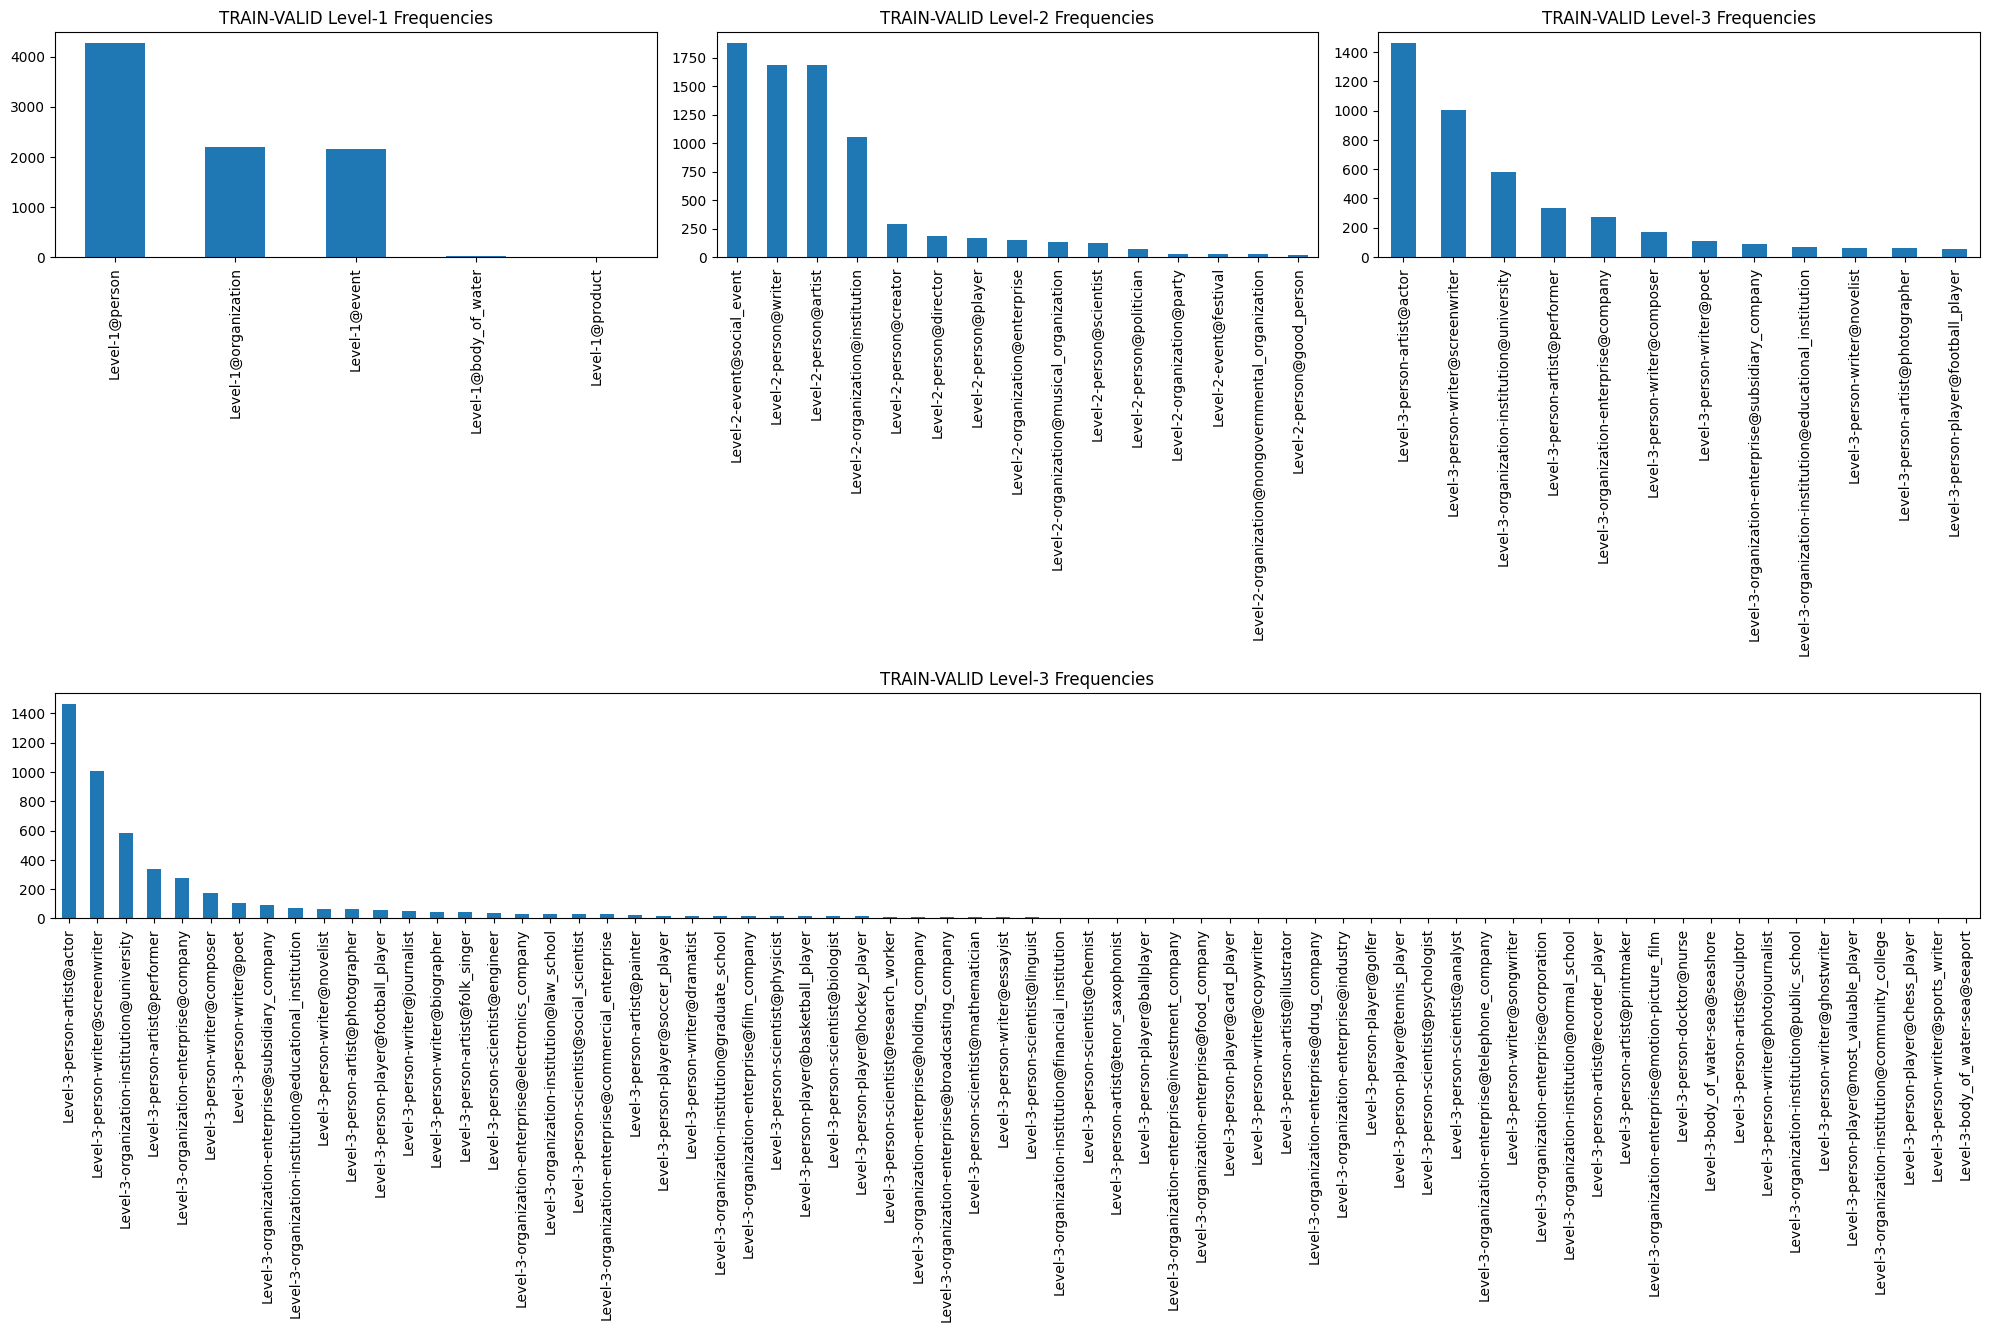

In [89]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,16))
# plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(3, 9, (1, 3))
df_ent['level-1-cleaned'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('TRAIN-VALID Level-1 Frequencies')

ax2 = fig.add_subplot(3, 9, (4, 6))
df_ent['level-2-cleaned'].value_counts().loc[lambda x: x > 10].plot(ax=ax2, kind='bar')
ax2.set_title('TRAIN-VALID Level-2 Frequencies')

ax4 = fig.add_subplot(3, 9, (7, 9))
df_ent['level-3-cleaned'].value_counts().loc[lambda x: x > 50].plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('TRAIN-VALID Level-3 Frequencies')

ax5 = fig.add_subplot(3, 9, (10, 18))
df_ent['level-3-cleaned'].value_counts().plot(ax=ax5, kind='bar', legend=False)
ax5.set_title('TRAIN-VALID Level-3 Frequencies')

In [93]:
pd.DataFrame(df_ent['level-3-cleaned'].value_counts()).to_csv("level3.csv")

In [77]:
# Level 1
from collections import defaultdict

level_items = defaultdict(int)

for items in df_ent['level-3']:
    for item in items:
        level_items[item] += 1

In [78]:
level_items

defaultdict(int,
            {'Level-3-person-writer@screenwriter': 1020,
             'Level-3-person-artist@actor': 2581,
             'Level-3-person-writer@scriptwriter': 1020,
             'Level-3-person-artist@performer': 3037,
             'Level-3-person-writer@journalist': 132,
             'Level-3-person-writer@poet': 281,
             'Level-3-person-writer@dramatist': 303,
             'Level-3-person-writer@novelist': 270,
             'Level-3-person-writer@biographer': 141,
             'Level-3-person-writer@essayist': 93,
             'Level-3-person-writer@sports_writer': 5,
             'Level-3-organization-institution@university': 643,
             'Level-3-organization-institution@educational_institution': 722,
             'Level-3-person-writer@composer': 852,
             'Level-3-person-writer@songwriter': 502,
             'Level-3-person-artist@photographer': 104,
             'Level-3-person-artist@cameraman': 81,
             'Level-3-person-player@footb